[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# CLIP

[CLIP](https://github.com/openai/CLIP) (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs by OpenAI. 

It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task, similarly to the zero-shot capabilities of GPT-2 and 3. We found CLIP matches the performance of the original ResNet50 on ImageNet “zero-shot” without using any of the original 1.28M labeled examples, overcoming several major challenges in computer vision.


![](https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png)

In [ ]:
# Uncomment the code below if you use google colab:
#%pip install git+https://github.com/openai/CLIP.git
#%mkdir data
#%cd data
#!wget https://raw.githubusercontent.com/dataflowr/notebooks/master/Module19/data/cat.jpg
#!wget https://raw.githubusercontent.com/dataflowr/notebooks/master/Module19/data/dog.png
#!wget https://raw.githubusercontent.com/dataflowr/notebooks/master/Module19/data/caltech101_full.json
#%cd ..

In [1]:
import torch
import clip
from PIL import Image
import numpy as np

In [2]:
dog_image = Image.open("data/dog.png")
cat_image = Image.open("data/cat.jpg")

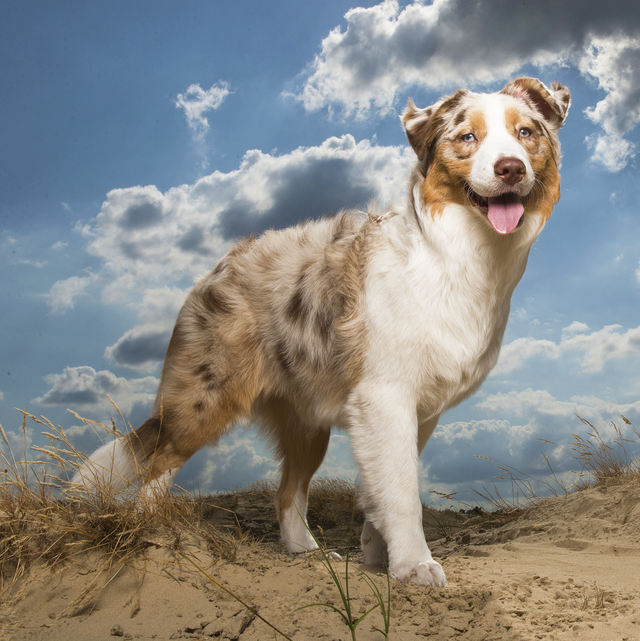

In [3]:
dog_image

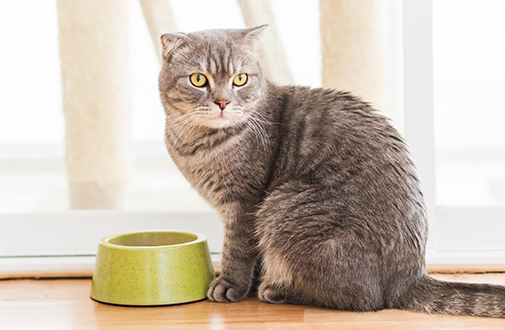

In [4]:
cat_image

# First use of CLIP

Use the [code snippets](https://github.com/openai/CLIP#usage) in order to get the good labels for the 2 images above.

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(dog_image).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)

Label probs: [[0.001644 0.9956   0.002586]]


In [6]:
image = preprocess(cat_image).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)

Label probs: [[0.00899 0.01529 0.9756 ]]


Note that in the code provided, the features for the text and for the image are not used. Check that the probabilities can be recovered from these features directly.

In [7]:
image_features.shape

torch.Size([1, 512])

In [8]:
text_features.shape

torch.Size([3, 512])

In [9]:
cos = torch.nn.CosineSimilarity()
cos(image_features, text_features)

tensor([0.2006, 0.2059, 0.2474], device='cuda:0', dtype=torch.float16)

In [10]:
logits_per_image

tensor([[20.0625, 20.5938, 24.7500]], device='cuda:0', dtype=torch.float16)

In [11]:
logits_per_text

tensor([[20.0625],
        [20.5938],
        [24.7500]], device='cuda:0', dtype=torch.float16)

# Building a classifier from CLIP

Check that the classifier below is working for the images above.

In [12]:
class Classifier_CLIP:
    def __init__(self, labels):
        self.labels = labels
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
        self.text = clip.tokenize(labels).to(self.device)
        
    def classify(self, image_pil, verbose=False):
        image = self.preprocess(image_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, logits_per_text = self.model(image, self.text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            if verbose:
                print('predicted class: ', self.labels[np.argmax(probs)])
        return np.argmax(probs)

In [13]:
labels = ["a diagram", "a dog", "a cat"]
classifier = Classifier_CLIP(labels)

In [14]:
classifier.classify(dog_image, verbose=True)

predicted class:  a dog


1

In [15]:
classifier.classify(cat_image, verbose=True)

predicted class:  a cat


2

# Testing the classifier on Caltech 101 

Now we want to see what are the performances of this classifier on the [Caltech 101](https://data.caltech.edu/records/mzrjq-6wc02) dataset.

You first need to download the dataset with [torchvision](https://pytorch.org/vision/stable/generated/torchvision.datasets.Caltech101.html#torchvision.datasets.Caltech101)

In [16]:
import torchvision
caltech_data = torchvision.datasets.Caltech101('data/', download=True)

Files already downloaded and verified


In [17]:
caltech_data

Dataset Caltech101
    Number of datapoints: 8677
    Root location: /home/mlelarge/data/caltech101
    Target type: ['category']

In [18]:
k = 4578
caltech_data[k]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=192x300>, 34)

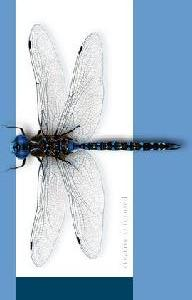

In [19]:
caltech_data[k][0]

In [20]:
caltech_data.categories[caltech_data[k][1]]

'dragonfly'

Now, you need to add methods to the `Classifier_CLIP` class. You can see on this [nice blogpost of Sean Osier](https://www.seanosier.com/2021/03/20/python-add-method-existing-class/) how to do it.

First make a method to create the texts corresponding to the labels and tokenize them. Once this is done check what is the prediction made by the classifier on the image above. Is it right?

In [21]:
def make_texts(self):
    texts = [f"A photo of a {t}" for t in self.labels]
    self.text = clip.tokenize(texts).to(self.device)
    pass

In [22]:
Classifier_CLIP.make_texts = make_texts

In [23]:
classifier_caltech = Classifier_CLIP(caltech_data.categories)

In [24]:
classifier_caltech.make_texts()

In [25]:
classifier_caltech.classify(caltech_data[k][0], verbose='True')

predicted class:  mayfly


62

Now, add two methods: `predict` will take a batch of images and compute the corresponding probabilities and predictions and `test` will take as input a dataloader and use predict to compute the accuracy of the classifier on the dataset.

Hint: to create the dataloader you can use `from more_itertools import chunked`

In [26]:
def predict(self, images_pil):
    images = torch.stack([self.preprocess(image).to(device) for image in images_pil])
    with torch.no_grad():
        logits_per_image, logits_per_text = self.model(images, self.text)
        probs = logits_per_image.softmax(dim=-1)
    return probs, probs.argmax(dim=1).cpu().numpy()

In [27]:
Classifier_CLIP.predict = predict

In [28]:
from more_itertools import chunked
dataloader = chunked(iter(caltech_data), 10)

In [29]:
def test(self, dataloader):
    total_acc = 0
    total_l = 0
    for batch in dataloader:
        batch_image = [t[0] for t in batch]
        batch_labels = [t[1] for t in batch]
        _, preds = self.predict(batch_image)
        total_acc += np.sum(preds == batch_labels)
        total_l += len(batch_labels)
    return total_acc, total_l

In [30]:
Classifier_CLIP.test = test

In [31]:
dataloader = chunked(iter(caltech_data), 100)
t_acc, t_l = classifier_caltech.test(dataloader)

In [32]:
print('Zero-shot accuracy with CLIP: ', t_acc / t_l)

Zero-shot accuracy with CLIP:  0.8543275325573355


# Better performances with GPT!

Using the idea of [Visual Classification via Description from Large Language Models](https://github.com/sachit-menon/classify_by_description_release/tree/master#visual-classification-via-description-from-large-language-models) by Sachit Menon, Carl Vondrick (ICLR 2023), try to get better performances!
![](https://raw.githubusercontent.com/sachit-menon/classify_by_description_release/master/figs/latent-points.png)

If you do not want to do prompt engineering, there are descriptors provided in the file `caltech101_full.json`

In [33]:
import json

def load_descriptors(self, filename):
    # Opening JSON file
    f = open(filename)
    self.descriptors = json.load(f)
    pass

In [34]:
Classifier_CLIP.load_descriptors = load_descriptors

In [35]:
classifier_caltech.load_descriptors('data/caltech101_full.json')

In [36]:
classifier_caltech.descriptors

{'Faces': ['Two eyes',
  'Eyebrows',
  'Nose',
  'Mouth',
  'Ears',
  'Hair',
  'Facial contours',
  'Skin complexion'],
 'Faces_easy': ['Two eyes ',
  'A nose ',
  'A mouth ',
  'Eyebrows ',
  'Eyelashes ',
  'Ears ',
  'Facial hair (if any) ',
  'Different skin tones and complexions ',
  'Expressions and emotions'],
 'Leopards': ['Large, muscular feline',
  'Tan or golden coat with distinctive black spots',
  'Strong and agile body',
  'Rounded ears',
  'Sharp, retractable claws',
  'Powerful jaws',
  'Long tail',
  'Intense and focused gaze'],
 'Motorbikes': ['Two-wheeled vehicle',
  'Handlebars for steering',
  'Seat for the rider',
  'Engine compartment',
  'Wheels with tires',
  'Exhaust pipes',
  'Headlights and taillights ',
  'Suspension system ',
  'Frame structure ',
  'Brake system'],
 'accordion': ['musical instrument',
  'box-shaped with a folded bellows',
  'piano-style keys',
  'buttons or switches on the front',
  'strap or belt for wearing',
  'decorative design eleme

Here, I am doing something very simple: replacing each label by `min_d=4` descriptors. Hence each consecutive group of 4 descriptors correspond to a given label and I will use `AvgPool1d` to get the score corresponding to a given label.

In [37]:
def create_texts(self):
    self.all_d_val = self.descriptors.values()
    self.all_d_key = self.descriptors.keys()
    self.min_d = min([len(v) for v in self.all_d_val])
    self.all_d_truncated = [v for val in self.all_d_val for v in val[:self.min_d]]
    self.text_d = clip.tokenize(self.all_d_truncated).to(self.device)
    pass

In [38]:
Classifier_CLIP.create_texts = create_texts

In [39]:
classifier_caltech.create_texts()

In [43]:
classifier_caltech.min_d

4

In [40]:
def classify_descriptors(self, image_pil, verbose=False):
        image = self.preprocess(image_pil).unsqueeze(0).to(device)
        av_pool = torch.nn.AvgPool1d(self.min_d)
        with torch.no_grad():
            logits_per_image, logits_per_text = self.model(image, self.text_d)
            probs_c = av_pool(logits_per_image).softmax(dim=-1).cpu().numpy()
            if verbose:
                print('predicted class: ', self.labels[np.argmax(probs_c)])
        return np.argmax(probs_c)

In [41]:
Classifier_CLIP.classify_descriptors = classify_descriptors

In [42]:
k=4578
classifier_caltech.classify_descriptors(caltech_data[k][0], verbose=True)

predicted class:  dragonfly


34

As we see above, this method allows to recover the right label for the iamge `4578` of a dragonfly. Unfortunately, the general performance of this method is not very good as shown below:

In [44]:
def predict_descriptors(self, images_pil):
    images = torch.stack([self.preprocess(image).to(device) for image in images_pil])
    av_pool = torch.nn.AvgPool1d(self.min_d)
    with torch.no_grad():
        logits_per_image, logits_per_text = self.model(images, self.text_d)
        probs_c = av_pool(logits_per_image)
    return probs_c, probs_c.argmax(dim=1).cpu().numpy()

def test_descriptors(self, dataloader):
    total_acc = 0
    total_l = 0
    for batch in dataloader:
        batch_image = [t[0] for t in batch]
        batch_labels = [t[1] for t in batch]
        _, preds = self.predict_descriptors(batch_image)
        total_acc += np.sum(preds == batch_labels)
        total_l += len(batch_labels)
    return total_acc, total_l

Classifier_CLIP.predict_descriptors = predict_descriptors
Classifier_CLIP.test_descriptors = test_descriptors

In [45]:
dataloader = chunked(iter(caltech_data), 100)
t_acc_d, t_l_d = classifier_caltech.test_descriptors(dataloader)

In [46]:
print('Zero-shot accuracy with CLIP: ', t_acc_d / t_l_d)

Zero-shot accuracy with CLIP:  0.5431600783680995


Here is a method giving better results:

In [47]:
def list2string(l):
    return '; '.join(l)[:250]

def new_create_texts(self):
    self.all_d_key = self.descriptors.keys()
    self.text = clip.tokenize([f"A photo of a {k} which has " + list2string(self.descriptors[k]) for k in self.all_d_key]).to(self.device)
    pass

In [48]:
Classifier_CLIP.new_create_texts = new_create_texts

In [49]:
classifier_caltech.new_create_texts()

In [50]:
dataloader = chunked(iter(caltech_data), 100)
t_acc_n, t_l_n = classifier_caltech.test(dataloader)

In [51]:
print('Zero-shot accuracy with CLIP: ', t_acc_n / t_l_n)

Zero-shot accuracy with CLIP:  0.8651607698513311


# Prompt engineering for image classification

As seen above, we did not improve much compared to the naive zero-shot algorithm. It should be possible to get better descriptors!

Below you will find the code used to find the descriptors in the `caltech101_full.json` and it should be easy to do better...

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = # your key here

def stringtolist(description):
    return [descriptor[2:] for descriptor in description.split('\n') if (descriptor != '') and (descriptor.startswith('- '))]

I am using the same [prompts as in the original paper](https://github.com/sachit-menon/classify_by_description_release/blob/master/generate_descriptors.py) adapted to the new API. It could be improved...

In [ ]:
from openai import OpenAI
client = OpenAI()

response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What are useful visual features for distinguishing a lemur in a photo?"},
    {"role": "assistant", "content": """There are several useful visual features to tell there is a lemur in a photo:
- four-limbed primate
- black, grey, white, brown, or red-brown
- wet and hairless nose with curved nostrils
- long tail
- large eyes
- furry bodies
- clawed hands and feet"""},
    {"role": "user", "content": "What are useful visual features for distinguishing a television in a photo?"},
    {"role": "assistant", "content": """There are several useful visual features to tell there is a television in a photo:
- electronic device
- black or grey
- a large, rectangular screen
- a stand or mount to support the screen
- one or more speakers
- a power cord
- input ports for connecting to other devices
- a remote control"""},
    {"role": "user", "content": "What are useful visual features for distinguishing a dragonfly in a photo? Provide an answer following the above pattern, give only the list of visual features."}
  ]
)

In [ ]:
response.choices[0].message.content

In [ ]:
def generate_prompt(category_name: str):
    # you can replace the examples with whatever you want; these were random and worked, could be improved
    return [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What are useful visual features for distinguishing a lemur in a photo?"},
    {"role": "assistant", "content": """There are several useful visual features to tell there is a lemur in a photo:
- four-limbed primate
- black, grey, white, brown, or red-brown
- wet and hairless nose with curved nostrils
- long tail
- large eyes
- furry bodies
- clawed hands and feet"""},
    {"role": "user", "content": "What are useful visual features for distinguishing a television in a photo?"},
    {"role": "assistant", "content": """There are several useful visual features to tell there is a television in a photo:
- electronic device
- black or grey
- a large, rectangular screen
- a stand or mount to support the screen
- one or more speakers
- a power cord
- input ports for connecting to other devices
- a remote control"""},
    {"role": "user", "content": f"What are useful visual features for distinguishing a {category_name} in a photo? Provide an answer following the above pattern, give only the list of visual features."}
  ]

def obtain_descriptors_and_save(filename, class_list):
    responses = {}
    descriptors = {}
    prompts = [generate_prompt(category.replace('_', ' ')) for category in class_list]
    client = OpenAI()

    responses = [client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages= prompt
    ) for prompt in prompts]
    
    
    response_texts = [resp.choices[0].message.content for resp in responses]
    descriptors_list = [stringtolist(response_text) for response_text in response_texts]
    descriptors = {cat: descr for cat, descr in zip(class_list, descriptors_list)}

    # save descriptors to json file
    if not filename.endswith('.json'):
        filename += '.json'
    with open(filename, 'w') as fp:
        json.dump(descriptors, fp)